In [46]:
import numpy as np
def stadium_mask(X, Y, a, b, rx, ry):
    rect = (np.abs(X) <= a) & (np.abs(Y) <= b)
    left_ellipse = ((X + a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X <= -a)
    right_ellipse = ((X - a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X >= a)
    return rect | left_ellipse | right_ellipse

Loschmidt echo a=1.100: 100%|██████████| 2000/2000 [00:02<00:00, 690.73it/s]


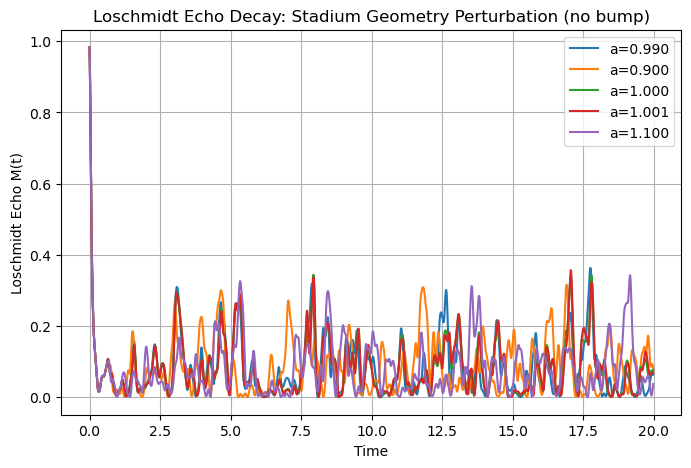

In [57]:
# Loschmidt echo with only stadium geometry perturbation (varying 'a', no bump)
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.sparse import csr_matrix, eye
from scipy.sparse.linalg import splu

# Parameters for echo
a=1
echo_steps = 2000
perturbations_a = [a*0.99, a*0.90, a, a*1.001, a*1.10] 
echo_results = {}
a = 1.0
b = 1.0
rx = 2.0
ry = b
hbar = 1.0
m = 1.0
Nx, Ny = 256, 256  # coarser grid for sparse solving
dt = 0.01

T_steps = 15000
sigma = 0.2
x0, y0 = 0,0
px, py = 1.0, 1.0

# Define grid
x = np.linspace(-a - rx, a + rx, Nx) * 1.5
y = np.linspace(-b - ry, b + ry, Ny) * 1.5
dx = (x.max() - x.min()) / (Nx - 1)  # Compute actual dx
dy = (y.max() - y.min()) / (Ny - 1)  # Compute actual dy
X, Y = np.meshgrid(x, y)

# Define initial Gaussian wavepacket and flatten
psi0 = np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j * (px*X + py*Y))
psi0_flat = psi0.flatten()

# Build 2D Laplacian operator for Nx x Ny grid
from scipy.sparse import diags, kron, identity

main_diag_x = -2.0 * np.ones(Nx)
off_diag_x = np.ones(Nx - 1)
Lx = diags([main_diag_x, off_diag_x, off_diag_x], [0, -1, 1], shape=(Nx, Nx)) / dx**2

main_diag_y = -2.0 * np.ones(Ny)
off_diag_y = np.ones(Ny - 1)
Ly = diags([main_diag_y, off_diag_y, off_diag_y], [0, -1, 1], shape=(Ny, Ny)) / dy**2

L = kron(identity(Ny), Lx) + kron(Ly, identity(Nx))

for a_p in perturbations_a:
    # Recompute mask and free points for perturbed stadiumi
    mask_pert = stadium_mask(X, Y, a_p, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)

    # Project initial wavepacket to perturbed stadium
    psi0_pert = psi0_flat[free_points_pert]
    norm_init_pert = np.sum(np.abs(psi0_pert)**2) * dx * dy
    psi0_pert /= np.sqrt(norm_init_pert)

    # Build Laplacian and Hamiltonian for perturbed stadium
    # Use same Laplacian construction as initial
    mask_full_pert = np.zeros(Nx*Ny, dtype=bool)
    mask_full_pert[free_points_pert] = True
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = P_pert @ L @ P_pert.T
    I_pert = eye(Nfree_pert)
    H_pert = - (hbar**2) / (2*m) * L_pert

    # Crank-Nicolson matrices for perturbed stadium
    A_pert = (I_pert + 1j * dt / (2*hbar) * H_pert).tocsc()
    B_pert = (I_pert - 1j * dt / (2*hbar) * H_pert).tocsc()
    LU_pert = splu(A_pert)

    # Loschmidt echo evolution
    psi_bwd = psi0_pert.copy()
    M_t = []
    for t in tqdm(range(echo_steps), desc=f'Loschmidt echo a={a_p:.3f}'):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        overlap = np.vdot(psi0_pert, psi_bwd) * dx * dy
        M_t.append(np.abs(overlap)**2)
    echo_results[a_p] = M_t

# Plot Loschmidt echo for all a perturbations
times_echo = np.arange(echo_steps) * dt
plt.figure(figsize=(8,5))
for a_p, M_t in echo_results.items():
    plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo Decay: Stadium Geometry Perturbation (no bump)')
plt.legend()
plt.grid(True)
plt.show()

Loschmidt echo a=3.000: 100%|██████████| 2000/2000 [00:05<00:00, 333.70it/s]


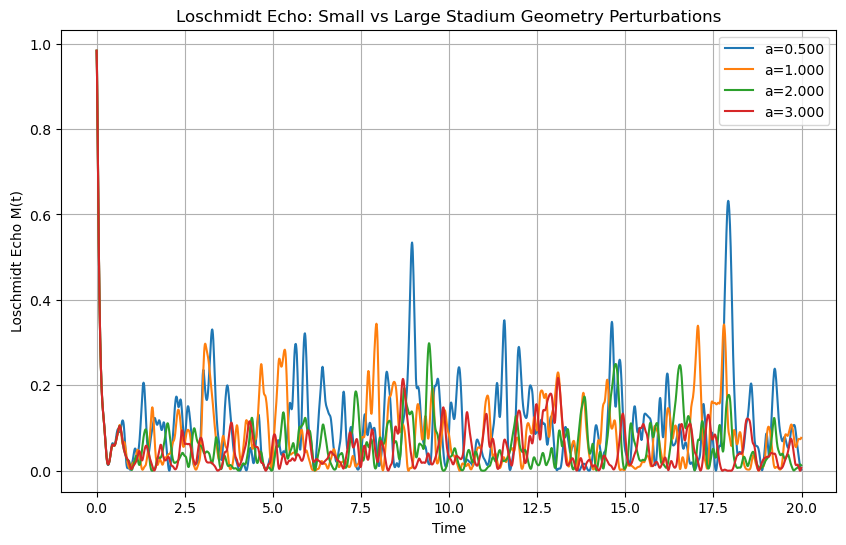

In [58]:
# Compare Loschmidt echo for smaller and larger stadium geometry perturbations
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters for echo
# Use a range of small and large perturbations
perturbations_a = [a*0.5,a , a*2,a*3]
echo_steps = 2000
echo_results = {}

for a_p in perturbations_a:
    # Recompute mask and free points for perturbed stadium
    mask_pert = stadium_mask(X, Y, a_p, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)

    # Project initial wavepacket to perturbed stadium
    psi0_pert = psi0_flat[free_points_pert]
    norm_init_pert = np.sum(np.abs(psi0_pert)**2) * dx * dy
    psi0_pert /= np.sqrt(norm_init_pert)

    # Build Laplacian and Hamiltonian for perturbed stadium
    mask_full_pert = np.zeros(Nx*Ny, dtype=bool)
    mask_full_pert[free_points_pert] = True
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = P_pert @ L @ P_pert.T
    I_pert = eye(Nfree_pert)
    H_pert = - (hbar**2) / (2*m) * L_pert

    # Crank-Nicolson matrices for perturbed stadium
    A_pert = (I_pert + 1j * dt / (2*hbar) * H_pert).tocsc()
    B_pert = (I_pert - 1j * dt / (2*hbar) * H_pert).tocsc()
    LU_pert = splu(A_pert)

    # Loschmidt echo evolution
    psi_bwd = psi0_pert.copy()
    M_t = []
    for t in tqdm(range(echo_steps), desc=f'Loschmidt echo a={a_p:.3f}'):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        overlap = np.vdot(psi0_pert, psi_bwd) * dx * dy
        M_t.append(np.abs(overlap)**2)
    echo_results[a_p] = M_t

# Plot Loschmidt echo for all a perturbations
times_echo = np.arange(echo_steps) * dt
plt.figure(figsize=(10,6))
for a_p, M_t in echo_results.items():
    plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo: Small vs Large Stadium Geometry Perturbations')
plt.legend()
plt.grid(True)
plt.show()

Loschmidt echo a=4.000: 100%|██████████| 1000/1000 [00:02<00:00, 340.07it/s]


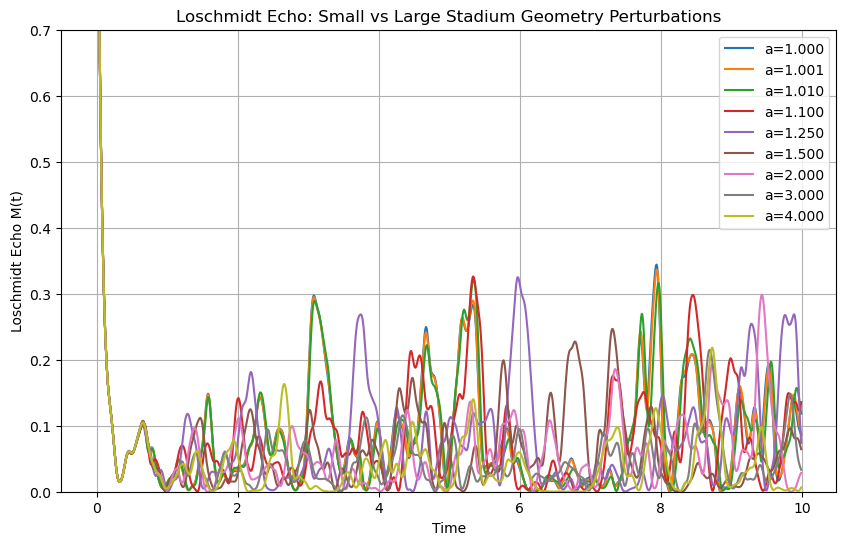

In [ ]:
dt = 0.01  # Decreased time step for finer evolution

# Compare Loschmidt echo for smaller and larger stadium geometry perturbations
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Parameters for echo
perturbations_a = [ a*1.0001,a*1.001,a*1.01,a*1.10, a*1.25,a*1.5, a*2.0, a*3.0,a*4.0]
factor = 1e-3
perturbations_a = [p * factor for p in perturbations_a] 
echo_steps = 1000
echo_results = {}

for a_p in perturbations_a:
    # Recompute mask and free points for perturbed stadium
    mask_pert = stadium_mask(X, Y, a_p, b, rx, ry)
    free_points_pert = np.where(mask_pert.flatten())[0]
    Nfree_pert = len(free_points_pert)

    # Project initial wavepacket to perturbed stadium
    psi0_pert = psi0_flat[free_points_pert]
    norm_init_pert = np.sum(np.abs(psi0_pert)**2) * dx * dy
    psi0_pert /= np.sqrt(norm_init_pert)

    # Build Laplacian and Hamiltonian for perturbed stadium
    mask_full_pert = np.zeros(Nx*Ny, dtype=bool)
    mask_full_pert[free_points_pert] = True
    rows_pert, cols_pert, data_pert = [], [], []
    for i, idx in enumerate(free_points_pert):
        rows_pert.append(i)
        cols_pert.append(idx)
        data_pert.append(1)
    P_pert = csr_matrix((data_pert, (rows_pert, cols_pert)), shape=(Nfree_pert, Nx*Ny))
    L_pert = P_pert @ L @ P_pert.T
    I_pert = eye(Nfree_pert)
    H_pert = - (hbar**2) / (2*m) * L_pert

    # Crank-Nicolson matrices for perturbed stadium
    A_pert = (I_pert + 1j * dt / (2*hbar) * H_pert).tocsc()
    B_pert = (I_pert - 1j * dt / (2*hbar) * H_pert).tocsc()
    LU_pert = splu(A_pert)

    # Loschmidt echo evolution
    psi_bwd = psi0_pert.copy()
    M_t = []
    for t in tqdm(range(echo_steps), desc=f'Loschmidt echo a={a_p:.3f}'):
        b_vec = B_pert @ psi_bwd
        psi_bwd = LU_pert.solve(b_vec)
        overlap = np.vdot(psi0_pert, psi_bwd) * dx * dy
        M_t.append(np.abs(overlap)**2)
    echo_results[a_p] = M_t

# Plot Loschmidt echo for all a perturbations
times_echo = np.arange(echo_steps) * dt

# Plot Loschmidt echo for all a perturbations with y-axis limited to 0.2
plt.figure(figsize=(10,6))
for a_p, M_t in echo_results.items():
    plt.plot(times_echo, M_t, label=f'a={a_p:.3f}')
plt.xlabel('Time')
plt.ylabel('Loschmidt Echo M(t)')
plt.title('Loschmidt Echo: Small vs Large Stadium Geometry Perturbations')
plt.ylim(0, 0.7)
plt.legend()
plt.grid(True)
plt.show()

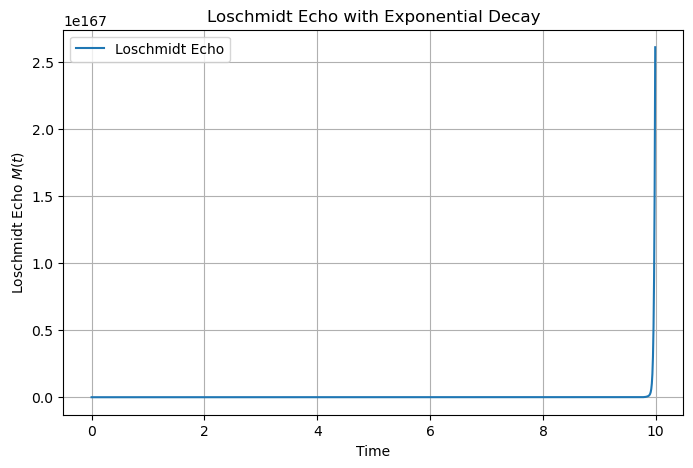

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 100  # Number of lattice points
dx = 1.0  # Lattice spacing
dt = 0.01  # Time step
hbar = 1.0  # Reduced Planck's constant
m = 1.0  # Mass
V0 = 0.1  # Perturbation strength
T_steps = 1000  # Number of time steps

# Define the 1D Laplacian operator
def laplacian_1d(N, dx):
    main_diag = -2.0 * np.ones(N)
    off_diag = np.ones(N - 1)
    L = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1)
    return L / dx**2

# Build the unperturbed Hamiltonian
Laplacian = laplacian_1d(L, dx)
H0 = -(hbar**2) / (2 * m) * Laplacian

# Add a small perturbation to the Hamiltonian
H_pert = H0 + V0 * np.diag(np.random.uniform(-1, 1, L))

# Initial Gaussian wave packet
x = np.linspace(-L // 2, L // 2, L)
sigma = 5.0
k0 = 2.0 * np.pi / L  # Initial momentum
psi0 = np.exp(-x**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
psi0 /= np.linalg.norm(psi0)  # Normalize the wavefunction

# Time evolution operators
U0 = np.linalg.matrix_power(np.eye(L) - 1j * dt / hbar * H0, T_steps)
U_pert = np.linalg.matrix_power(np.eye(L) - 1j * dt / hbar * H_pert, T_steps)

# Loschmidt echo calculation
M_t = []
psi_t = psi0.copy()
for t in range(T_steps):
    psi_t = U_pert @ psi_t  # Evolve under perturbed Hamiltonian
    overlap = np.vdot(psi0, psi_t)  # Compute overlap with initial state
    M_t.append(np.abs(overlap)**2)  # Loschmidt echo

# Time array
times = np.arange(T_steps) * dt

# Plot Loschmidt echo
plt.figure(figsize=(8, 5))
plt.plot(times, M_t, label="Loschmidt Echo")
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo with Exponential Decay")
plt.grid(True)
plt.legend()
plt.show()

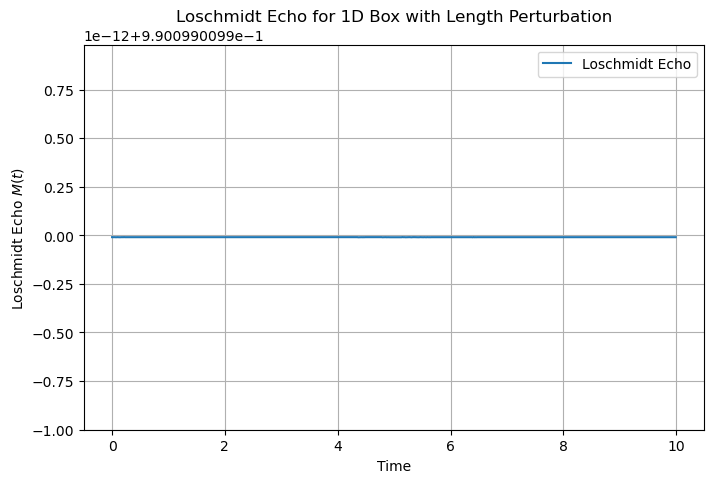

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 1.0  # Length of the unperturbed box
L_pert = 1.01 * L  # Length of the perturbed box (small perturbation)
hbar = 1.0  # Reduced Planck's constant
m = 1.0  # Mass of the particle
n = 1  # Quantum number of the initial state
T_steps = 1000  # Number of time steps
dt = 0.01  # Time step

# Define the energy eigenstates and eigenvalues for the box
def psi_box(x, n, L):
    """Wavefunction for the nth eigenstate in a box of length L."""
    return np.sqrt(2 / L) * np.sin(n * np.pi * x / L)

def energy_box(n, L):
    """Energy of the nth eigenstate in a box of length L."""
    return (n**2 * np.pi**2 * hbar**2) / (2 * m * L**2)

# Discretize the spatial domain
Nx = 500  # Number of spatial points
x = np.linspace(0, L, Nx)  # Spatial grid for the unperturbed box
x_pert = np.linspace(0, L_pert, Nx)  # Spatial grid for the perturbed box

# Initial wavefunction (unperturbed box)
psi0 = psi_box(x, n, L)

# Time evolution in the unperturbed box
E = energy_box(n, L)
omega = E / hbar  # Angular frequency
psi_t_unpert = lambda t: psi0 * np.exp(-1j * omega * t)

# Time evolution in the perturbed box
E_pert = energy_box(n, L_pert)
omega_pert = E_pert / hbar  # Angular frequency
psi_t_pert = lambda t: psi_box(x_pert, n, L_pert) * np.exp(-1j * omega_pert * t)

# Compute the Loschmidt echo
M_t = []
times = np.arange(T_steps) * dt
for t in times:
    # Overlap between the unperturbed and perturbed wavefunctions
    overlap = np.trapz(np.conj(psi_t_unpert(t)) * psi_t_pert(t), x)
    M_t.append(np.abs(overlap)**2)

# Plot the Loschmidt echo
plt.figure(figsize=(8, 5))
plt.plot(times, M_t, label="Loschmidt Echo")
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo for 1D Box with Length Perturbation")
plt.grid(True)
plt.legend()
plt.show()

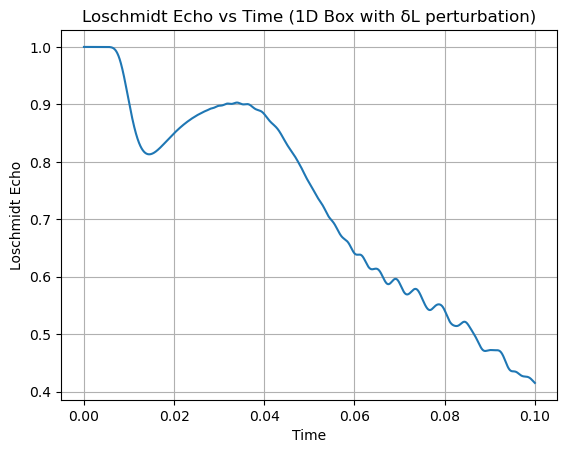

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants (in natural units for simplicity)
hbar = 1.0
m = 1.0

# Box parameters
L = 1.0           # original box length
delta_L = 0.01    # small perturbation in length
L_pert = L + delta_L

# Basis size
N_states = 100    # number of eigenstates to use

# Initial wavepacket parameters
x_points = 1000
x = np.linspace(0, L, x_points)
x0 = L / 2            # center of wavepacket
sigma = L / 20        # width of wavepacket
k0 = 10 * np.pi / L   # central wave number

# Construct initial wavepacket in position space
psi0_x = np.exp(-(x - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x)
psi0_x /= np.sqrt(np.trapz(np.abs(psi0_x)**2, x))  # normalize

# Eigenstates and energies
def phi_n(n, x, L_box):
    return np.sqrt(2 / L_box) * np.sin(n * np.pi * x / L_box)

def E_n(n, L_box):
    return (n * np.pi * hbar)**2 / (2 * m * L_box**2)

# Projection coefficients for unperturbed and perturbed systems
def get_coefficients(psi_x, L_box):
    coeffs = []
    for n in range(1, N_states + 1):
        phi = phi_n(n, x, L_box)
        c_n = np.trapz(np.conj(phi) * psi_x, x)
        coeffs.append(c_n)
    return np.array(coeffs)

c_n_unpert = get_coefficients(psi0_x, L)
c_n_pert = get_coefficients(psi0_x, L_pert)

# Time evolution
def psi_t(c_n, L_box, t):
    psi = np.zeros_like(x, dtype=complex)
    for n, c in enumerate(c_n, start=1):
        phi = phi_n(n, x, L_box)
        E = E_n(n, L_box)
        psi += c * phi * np.exp(-1j * E * t / hbar)
    return psi

# Loschmidt Echo over time
times = np.linspace(0, 0.1, 20000)
echo = []

for t in times:
    psi_unpert = psi_t(c_n_unpert, L, t)
    psi_pert = psi_t(c_n_pert, L_pert, t)
    
    # Back evolve psi_pert under H0
    c_n_pert_back = get_coefficients(psi_pert, L)
    psi_back = psi_t(c_n_pert_back, L, -t)
    
    # Loschmidt echo = |<ψ0 | ψ_back>|^2
    overlap = np.trapz(np.conj(psi0_x) * psi_back, x)
    echo.append(np.abs(overlap)**2)

# Plot
plt.plot(times, echo)
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo")
plt.title("Loschmidt Echo vs Time (1D Box with δL perturbation)")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from math import isfinite

# Stadium parameters
# Rectangle: |x| <= a, |y| <= b
# Ellipse caps: centered at x=±a, semi-axes rx, ry

a = 3.0    # half-width of rectangle
b = 1.0   # half-height of rectangle
rx = 2.0  # ellipse semi-axis in x (caps)
ry = b    # ellipse semi-axis in y
EPS = 1e-9 # tolerance for floating-point comparisons

def ellipse_quadratic_coeffs(x0, y0, vx, vy, cx):
    # ellipse centered at (cx,0): ((x-cx)/rx)^2 + (y/ry)^2 = 1
    dx0 = x0 - cx
    A = (vx*vx)/(rx*rx) + (vy*vy)/(ry*ry)
    B = 2*(dx0*vx)/(rx*rx) + 2*(y0*vy)/(ry*ry)
    C = (dx0*dx0)/(rx*rx) + (y0*y0)/(ry*ry) - 1.0
    return A, B, C

def solve_quadratic(A, B, C):
    # robust quadratic solver for real roots; returns sorted positive roots list
    if abs(A) < 1e-18:
        if abs(B) < 1e-18:
            return []
        t = -C / B
        return [t] if isfinite(t) else []
    disc = B*B - 4*A*C
    if disc < 0:
        return []
    sqrt_d = np.sqrt(disc)
    t1 = (-B - sqrt_d) / (2*A)
    t2 = (-B + sqrt_d) / (2*A)
    roots = []
    for t in (t1, t2):
        if isfinite(t):
            roots.append(t)
    roots = sorted(set(roots))
    return roots

def ellipse_normal_at(x, y, cx):
    # gradient of F = (x-cx)^2/rx^2 + y^2/ry^2 - 1 gives normal ~ ((x-cx)/rx^2, y/ry^2)
    nx = (x - cx)/(rx*rx)
    ny = y/(ry*ry)
    v = np.array([nx, ny])
    norm = np.linalg.norm(v)
    if norm == 0:
        return np.array([1.0, 0.0])
    return v / norm

def reflect(v, n):
    # reflect velocity vector v about (unit) normal n
    return v - 2*np.dot(v, n)*n
def kinetic_energy(vx, vy, mass=1.0):
    """Return kinetic energy for given velocity components and mass (default 1)."""
    return 0.5 * mass * (vx**2 + vy**2)
    


This is the norm before normalization: 1.00000000
Norms array (initial): [np.float64(0.9999999999999998)]
Crank-CN: 0%
Crank-CN: 5%
Crank-CN: 10%
Crank-CN: 15%
Crank-CN: 20%
Crank-CN: 25%
Crank-CN: 30%
Crank-CN: 35%
Crank-CN: 40%
Crank-CN: 45%
Crank-CN: 50%
Crank-CN: 55%
Crank-CN: 60%
Crank-CN: 65%
Crank-CN: 70%
Crank-CN: 75%
Crank-CN: 80%
Crank-CN: 85%
Crank-CN: 90%
Crank-CN: 95%
Crank-CN: 100%
Fraction of norms within tolerance 1e-08: 1.0000


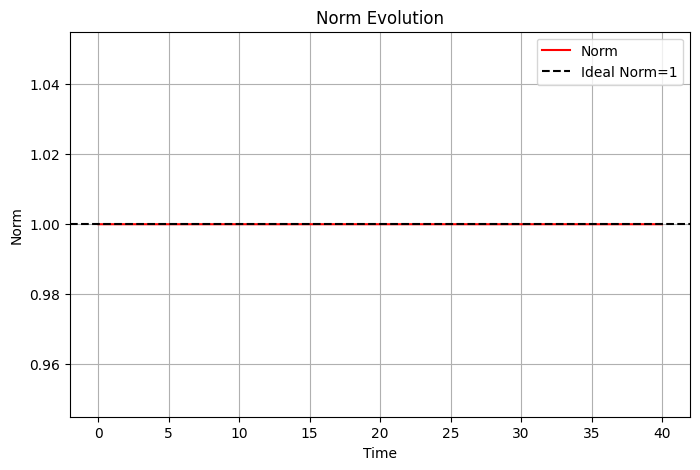

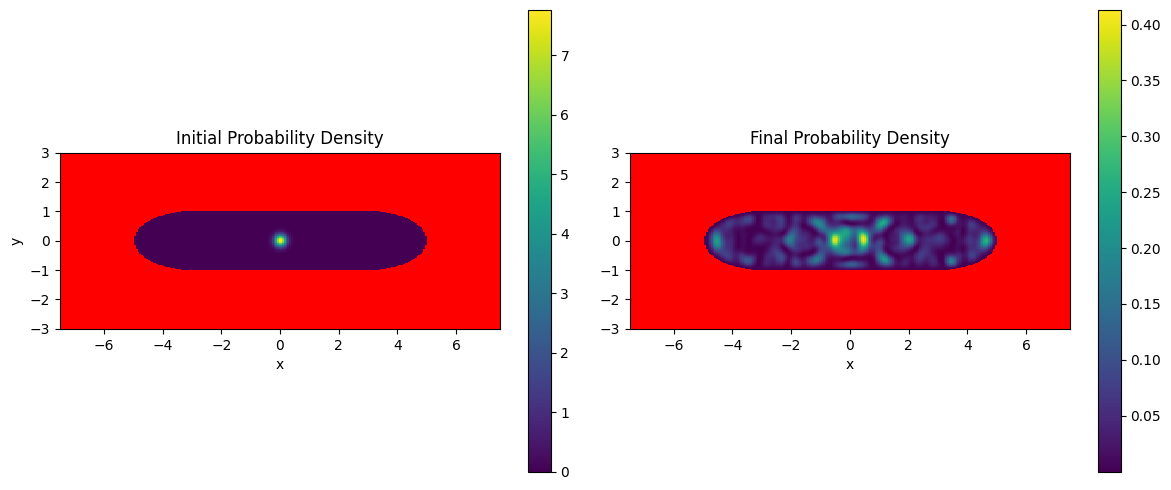

Norm range: 1.000000000000 to 1.000000000000, Final norm: 1.000000000000


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csr_matrix
from scipy.sparse.linalg import splu
from scipy.ndimage import distance_transform_edt

# Progress bar (tqdm) using tqdm.auto (no ipywidgets) with safe fallback if not installed
try:
    from tqdm.auto import tqdm as tqdm_nb
except Exception:
    try:
        from tqdm import tqdm as tqdm_nb
    except Exception:
        def tqdm_nb(iterable, desc=None):
            seq = list(iterable)
            total = len(seq)
            if total == 0:
                return iter([])
            def _gen():
                for i, v in enumerate(seq, 1):
                    if i == 1 or i == total or (i % max(1, total//20) == 0):
                        print(f"{desc or 'Progress'}: {int(i/total*100)}%")
                    yield v
            return _gen()

# Parameters
a = 3.0
b = 1.0
rx = 2.0
ry = b
hbar = 1.0
m = 1.0
Nx, Ny = 256, 256  # coarser grid for sparse solving
dt = 0.01

T_steps = 4000
sigma = 0.2
x0, y0 = 0,0
px, py = 1.0, 1.0

# Define grid
x = np.linspace(-a - rx, a + rx, Nx) * 1.5
y = np.linspace(-b - ry, b + ry, Ny) * 1.5
dx = (x.max() - x.min()) / (Nx - 1)  # Compute actual dx
dy = (y.max() - y.min()) / (Ny - 1)  # Compute actual dy
X, Y = np.meshgrid(x, y)

# Define stadium mask
def stadium_mask(X, Y, a, b, rx, ry):
    rect = (np.abs(X) <= a) & (np.abs(Y) <= b)
    left_ellipse = ((X + a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X <= -a)
    right_ellipse = ((X - a)**2 / rx**2 + Y**2 / ry**2 <= 1) & (X >= a)
    return rect | left_ellipse | right_ellipse

mask = stadium_mask(X, Y, a, b, rx, ry)
free_points = np.where(mask.flatten())[0]  # indices of grid points inside domain

# Number of free points
Nfree = len(free_points)

# Build finite difference Laplacian (5-point stencil) for interior points only
def laplacian_2d(Nx, Ny, dx, dy):
    ex = np.ones(Nx)
    ey = np.ones(Ny)
    Tx = diags([ex, -2*ex, ex], [-1, 0, 1], shape=(Nx,Nx)) / dx**2
    Ty = diags([ey, -2*ey, ey], [-1, 0, 1], shape=(Ny,Ny)) / dy**2
    L = kron(eye(Ny), Tx) + kron(Ty, eye(Nx))
    return L

L = laplacian_2d(Nx, Ny, dx, dy)

# Restrict to free points by masking the Laplacian matrix
L = L.tocsr()
identity = eye(Nx*Ny).tocsr()
mask_full = np.zeros(Nx*Ny, dtype=bool)
mask_full[free_points] = True

# Create projection matrix P to free points
rows = []
cols = []
data = []
for i, idx in enumerate(free_points):
    rows.append(i)
    cols.append(idx)
    data.append(1)
P = csr_matrix((data, (rows, cols)), shape=(Nfree, Nx*Ny))

# Reduced Laplacian and identity on free space
L_free = P @ L @ P.T
I_free = eye(Nfree)

# Hamiltonian in reduced space: H = -(ħ²/2m) Δ
H_free = - (hbar**2) / (2*m) * L_free

# Crank-Nicolson matrices
A = (I_free + 1j * dt / (2*hbar) * H_free).tocsc()
B = (I_free - 1j * dt / (2*hbar) * H_free).tocsc()

# LU factorization for fast solving
LU = splu(A)

# Initial wavefunction on full grid and flatten
psi0 = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2*sigma**2))
psi0 = psi0.astype(np.complex128)  # Ensure psi0 is complex before multiplying
psi0 *= np.exp(1j * (px * X + py * Y) / hbar)
psi0_flat = psi0.flatten()

# Restrict to free points only
psi_free = psi0_flat[free_points]

# Normalize initial wavefunction on free points
norm = np.sum(np.abs(psi_free)**2) * dx * dy
print(f"This is the norm before normalization: {norm:.8f}")
psi_free /= np.sqrt(norm)

# Time evolution storage
psi_t_free = [psi_free.copy()]
norms = [np.sum(np.abs(psi_free)**2) * dx * dy]
print(f"Norms array (initial): {norms}")

# Evolution loop with progress bar
for t in tqdm_nb(range(T_steps), desc="Crank-CN"):
    b_vec = B @ psi_free
    psi_free = LU.solve(b_vec)
    norms.append(np.sum(np.abs(psi_free)**2) * dx * dy)
    if t % 20 == 0:
        psi_t_free.append(psi_free.copy())

# Convert to numpy array and apply small-tolerance cleanup
norms = np.array(norms, dtype=float)
# Remove tiny numerical noise near zero
eps_tol = 1e-14
norms[np.abs(norms) < eps_tol] = 0.0

# Round off any values >= 0.99999999 to exactly 1.0
threshold = 0.99999999
norms = np.where(norms >= threshold, 1.0, norms)

# Use single tolerance when comparing to 1.0 (1e-8)
tol = 1e-8
close_to_one = np.isclose(norms, 1.0, rtol=tol, atol=tol)
frac_close = np.sum(close_to_one) / norms.size
print(f"Fraction of norms within tolerance {tol}: {frac_close:.4f}")

# Reconstruct psi on full grid for plotting
def reconstruct_full_grid(psi_free_vec):
    psi_full_vec = np.zeros(Nx*Ny, dtype=complex)
    psi_full_vec[free_points] = psi_free_vec
    return psi_full_vec.reshape(Ny, Nx)

# Plotting norm evolution
times = np.arange(len(norms)) * dt

plt.figure(figsize=(8,5))
ax = plt.gca()
ax.plot(times, norms, 'r-', label='Norm')
ax.axhline(1.0, color='k', linestyle='--', label='Ideal Norm=1')
ax.set_xlabel('Time')
ax.set_ylabel('Norm')
ax.set_title('Norm Evolution')
ax.legend()
ax.grid()

# Disable scientific offset on y-axis (prevent '×10^n' offset shown)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.show()

# Plot initial and final probability densities inside stadium
psi_init_full = reconstruct_full_grid(psi_t_free[0])
psi_final_full = reconstruct_full_grid(psi_t_free[-1])

fig, axes = plt.subplots(1,2, figsize=(12,5))

from matplotlib.colors import ListedColormap
mask2D = mask.reshape(Ny, Nx)
# background: red where probability is zero (outside mask)
bg = np.where(~mask2D, 1.0, np.nan)
cmap_bg = ListedColormap(['red'])

# Initial
axes[0].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_init = np.ma.array(np.abs(psi_init_full)**2, mask=~mask2D)
im0 = axes[0].imshow(prob_init, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[0].set_title('Initial Probability Density')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
plt.colorbar(im0, ax=axes[0])

# Final
axes[1].imshow(bg, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap=cmap_bg, vmin=0, vmax=1, interpolation='none')
prob_final = np.ma.array(np.abs(psi_final_full)**2, mask=~mask2D)
im1 = axes[1].imshow(prob_final, extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', cmap='viridis', interpolation='none')
axes[1].set_title('Final Probability Density')
axes[1].set_xlabel('x')
plt.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()

# Print stats with tolerance-aware min/max
min_norm = norms.min()
max_norm = norms.max()
print(f"Norm range: {min_norm:.12f} to {max_norm:.12f}, Final norm: {norms[-1]:.12f}")

In [2]:
pip install scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 10.9 MB/s  0:00:03m0:00:0100:01
Note: you may need to restart the kernel to use updated packages.


Echo: evolve H0 & H': 0%
Echo: evolve H0 & H': 5%
Echo: evolve H0 & H': 10%
Echo: evolve H0 & H': 15%
Echo: evolve H0 & H': 20%
Echo: evolve H0 & H': 25%
Echo: evolve H0 & H': 30%
Echo: evolve H0 & H': 35%
Echo: evolve H0 & H': 40%
Echo: evolve H0 & H': 45%
Echo: evolve H0 & H': 50%
Echo: evolve H0 & H': 55%
Echo: evolve H0 & H': 60%
Echo: evolve H0 & H': 65%
Echo: evolve H0 & H': 70%
Echo: evolve H0 & H': 75%
Echo: evolve H0 & H': 80%
Echo: evolve H0 & H': 85%
Echo: evolve H0 & H': 90%
Echo: evolve H0 & H': 95%
Echo: evolve H0 & H': 100%


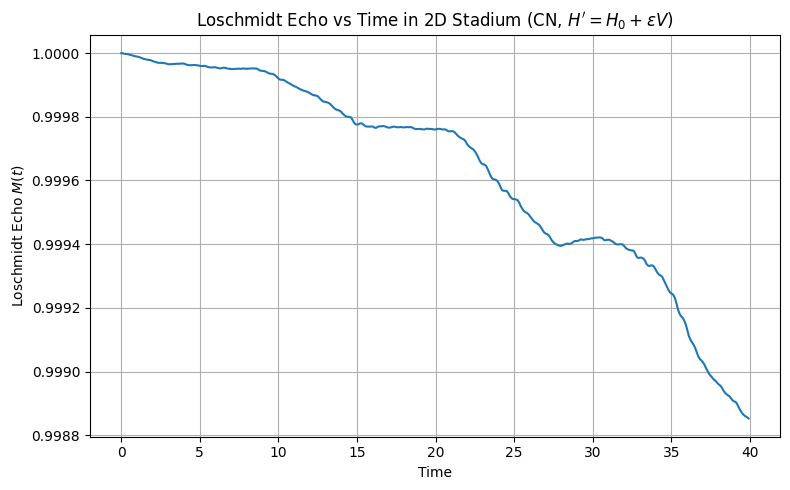

Unperturbed norm range: 1.000000000000 – 1.000000000001
Perturbed   norm range: 1.000000000000 – 1.000000000001


In [3]:
# === Add this block AFTER you create H_free, A, B, LU, and psi_free ===

# ---- Define a small perturbation V(x,y) on the SAME grid/mask ----
eps_V = 0.05         # perturbation strength (energy units)
xV, yV = 0.6, 0.0    # center of the Gaussian bump (in your coordinates)
sigma_V = 0.25       # width of the bump

V_full = eps_V * np.exp(-((X - xV)**2 + (Y - yV)**2) / (2*sigma_V**2))
V_vec  = V_full.flatten()
V_free = V_vec[free_points]                  # restrict to domain
Vop    = diags(V_free, 0, shape=(Nfree, Nfree)).tocsr()

# ---- Build perturbed Hamiltonian H' = H0 + V ----
H_free_pert = H_free + Vop

# ---- Crank–Nicolson matrices for H' ----
A_pert = (I_free + 1j * dt / (2*hbar) * H_free_pert).tocsc()
B_pert = (I_free - 1j * dt / (2*hbar) * H_free_pert).tocsc()
LU_pert = splu(A_pert)

# (Optional) LU for B and B_pert if you ever want explicit backward stepping:
# LU_B0    = splu(B.tocsc())
# LU_Bpert = splu(B_pert.tocsc())

# ---- Initialize two copies of the same normalized initial state ----
psi_unpert = psi_free.copy()   # evolves with H0
psi_pert   = psi_free.copy()   # evolves with H'

# ---- Time evolution and Loschmidt echo ----
echo_times = []
echo_vals  = []

# If you want to store norms to check unitarity on both branches:
norms_unpert = [np.sum(np.abs(psi_unpert)**2) * dx * dy]
norms_pert   = [np.sum(np.abs(psi_pert)**2)   * dx * dy]

sample_every = 10  # record echo every N steps (adjust to taste)

for n in tqdm_nb(range(T_steps), desc="Echo: evolve H0 & H'"):
    # One CN step under H0
    b0 = B @ psi_unpert
    psi_unpert = LU.solve(b0)

    # One CN step under H'
    bp = B_pert @ psi_pert
    psi_pert = LU_pert.solve(bp)

    if (n % sample_every) == 0:
        t = (n+1) * dt
        # Overlap on masked domain: <psi_H0(t) | psi_H'(t)>
        overlap = dx * dy * np.vdot(psi_unpert, psi_pert)   # vdot does conjugate on first arg
        M_t = np.abs(overlap)**2
        echo_times.append(t)
        echo_vals.append(M_t)

        # (Optional) track norms
        norms_unpert.append(np.sum(np.abs(psi_unpert)**2) * dx * dy)
        norms_pert.append(np.sum(np.abs(psi_pert)**2)   * dx * dy)

# ---- Plot Loschmidt Echo ----
plt.figure(figsize=(8,5))
plt.plot(echo_times, echo_vals, lw=1.5)
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo vs Time in 2D Stadium (CN, $H' = H_0 + \\varepsilon V$)")
plt.grid(True)
plt.tight_layout()
plt.show()

# (Optional) inspect norm preservation for both branches
if norms_unpert and norms_pert:
    print(f"Unperturbed norm range: {min(norms_unpert):.12f} – {max(norms_unpert):.12f}")
    print(f"Perturbed   norm range: {min(norms_pert):.12f} – {max(norms_pert):.12f}")


Echo (geom perturb): 0%
Echo (geom perturb): 5%
Echo (geom perturb): 10%
Echo (geom perturb): 15%
Echo (geom perturb): 20%
Echo (geom perturb): 25%
Echo (geom perturb): 30%
Echo (geom perturb): 35%
Echo (geom perturb): 40%
Echo (geom perturb): 45%
Echo (geom perturb): 50%
Echo (geom perturb): 55%
Echo (geom perturb): 60%
Echo (geom perturb): 65%
Echo (geom perturb): 70%
Echo (geom perturb): 75%
Echo (geom perturb): 80%
Echo (geom perturb): 85%
Echo (geom perturb): 90%
Echo (geom perturb): 95%
Echo (geom perturb): 100%


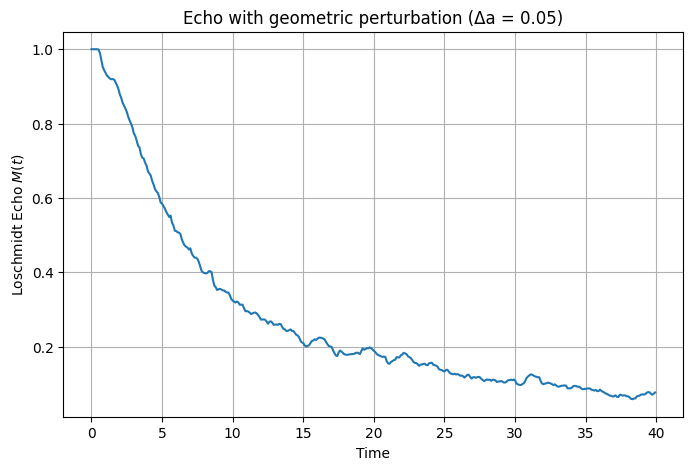

In [3]:
delta_a = 0.05   # small geometric perturbation

# --- Build two masks: unperturbed and perturbed ---
mask0 = stadium_mask(X, Y, a, b, rx, ry)
mask1 = stadium_mask(X, Y, a+delta_a, b, rx, ry)

free0 = np.where(mask0.flatten())[0]
free1 = np.where(mask1.flatten())[0]

def build_CN(free_points):
    mask_full = np.zeros(Nx*Ny, dtype=bool)
    mask_full[free_points] = True
    rows, cols, data = [], [], []
    for i, idx in enumerate(free_points):
        rows.append(i); cols.append(idx); data.append(1)
    P = csr_matrix((data, (rows, cols)), shape=(len(free_points), Nx*Ny))
    L_free = P @ L @ P.T
    I_free = eye(len(free_points))
    H_free = - (hbar**2)/(2*m) * L_free
    A = (I_free + 1j * dt / (2*hbar) * H_free).tocsc()
    B = (I_free - 1j * dt / (2*hbar) * H_free).tocsc()
    LU = splu(A)
    return P, H_free, A, B, LU, free_points

# Build both systems
P0, H0, A0, B0, LU0, free0 = build_CN(free0)
P1, H1, A1, B1, LU1, free1 = build_CN(free1)

# --- Initial wavefunction (same Gaussian on full grid) ---
psi0_full = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2)/(2*sigma**2))
psi0_full = psi0_full.astype(np.complex128) * np.exp(1j*(px*X+py*Y)/hbar)
psi0_vec = psi0_full.flatten()

# Restrict to each domain
psi0_free0 = psi0_vec[free0].copy()
psi0_free1 = psi0_vec[free1].copy()

# Normalize each
norm0 = np.sum(np.abs(psi0_free0)**2) * dx*dy
norm1 = np.sum(np.abs(psi0_free1)**2) * dx*dy
psi0_free0 /= np.sqrt(norm0)
psi0_free1 /= np.sqrt(norm1)

# --- Time evolution and Echo ---
echo_times, echo_vals = [], []

psi_free0 = psi0_free0.copy()
psi_free1 = psi0_free1.copy()

for n in tqdm_nb(range(T_steps), desc="Echo (geom perturb)"):
    # evolve H0
    b0 = B0 @ psi_free0
    psi_free0 = LU0.solve(b0)
    # evolve H1
    b1 = B1 @ psi_free1
    psi_free1 = LU1.solve(b1)

    if n % 10 == 0:
        t = (n+1)*dt
        # reconstruct to full grid
        psi_full0 = np.zeros(Nx*Ny, dtype=complex)
        psi_full1 = np.zeros(Nx*Ny, dtype=complex)
        psi_full0[free0] = psi_free0
        psi_full1[free1] = psi_free1
        # overlap on full domain
        overlap = dx*dy * np.vdot(psi_full0, psi_full1)
        echo = np.abs(overlap)**2
        echo_times.append(t)
        echo_vals.append(echo)

# --- Plot echo ---
plt.figure(figsize=(8,5))
plt.plot(echo_times, echo_vals)
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title(f"Echo with geometric perturbation (Δa = {delta_a})")
plt.grid(True)
plt.show()


Echo (geom perturb): 0%
Echo (geom perturb): 5%
Echo (geom perturb): 10%
Echo (geom perturb): 15%
Echo (geom perturb): 20%
Echo (geom perturb): 25%
Echo (geom perturb): 30%
Echo (geom perturb): 35%
Echo (geom perturb): 40%
Echo (geom perturb): 45%
Echo (geom perturb): 50%
Echo (geom perturb): 55%
Echo (geom perturb): 60%
Echo (geom perturb): 65%
Echo (geom perturb): 70%
Echo (geom perturb): 75%
Echo (geom perturb): 80%
Echo (geom perturb): 85%
Echo (geom perturb): 90%
Echo (geom perturb): 95%
Echo (geom perturb): 100%


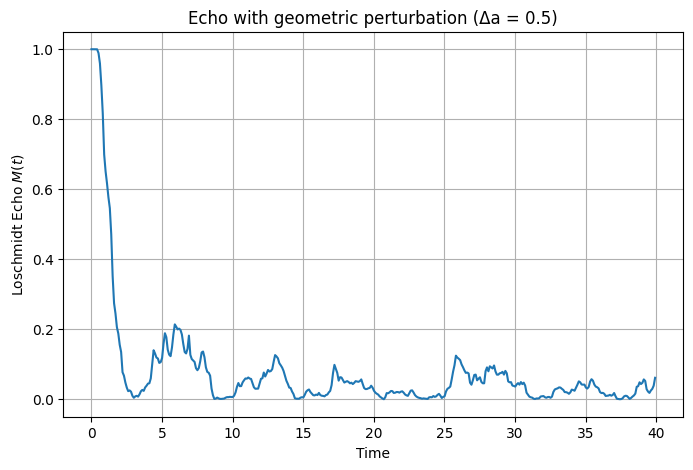

In [4]:
delta_a = 0.5   # small geometric perturbation

# --- Build two masks: unperturbed and perturbed ---
mask0 = stadium_mask(X, Y, a, b, rx, ry)
mask1 = stadium_mask(X, Y, a+delta_a, b, rx, ry)

free0 = np.where(mask0.flatten())[0]
free1 = np.where(mask1.flatten())[0]

def build_CN(free_points):
    mask_full = np.zeros(Nx*Ny, dtype=bool)
    mask_full[free_points] = True
    rows, cols, data = [], [], []
    for i, idx in enumerate(free_points):
        rows.append(i); cols.append(idx); data.append(1)
    P = csr_matrix((data, (rows, cols)), shape=(len(free_points), Nx*Ny))
    L_free = P @ L @ P.T
    I_free = eye(len(free_points))
    H_free = - (hbar**2)/(2*m) * L_free
    A = (I_free + 1j * dt / (2*hbar) * H_free).tocsc()
    B = (I_free - 1j * dt / (2*hbar) * H_free).tocsc()
    LU = splu(A)
    return P, H_free, A, B, LU, free_points

# Build both systems
P0, H0, A0, B0, LU0, free0 = build_CN(free0)
P1, H1, A1, B1, LU1, free1 = build_CN(free1)

# --- Initial wavefunction (same Gaussian on full grid) ---
psi0_full = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2)/(2*sigma**2))
psi0_full = psi0_full.astype(np.complex128) * np.exp(1j*(px*X+py*Y)/hbar)
psi0_vec = psi0_full.flatten()

# Restrict to each domain
psi0_free0 = psi0_vec[free0].copy()
psi0_free1 = psi0_vec[free1].copy()

# Normalize each
norm0 = np.sum(np.abs(psi0_free0)**2) * dx*dy
norm1 = np.sum(np.abs(psi0_free1)**2) * dx*dy
psi0_free0 /= np.sqrt(norm0)
psi0_free1 /= np.sqrt(norm1)

# --- Time evolution and Echo ---
echo_times, echo_vals = [], []

psi_free0 = psi0_free0.copy()
psi_free1 = psi0_free1.copy()

for n in tqdm_nb(range(T_steps), desc="Echo (geom perturb)"):
    # evolve H0
    b0 = B0 @ psi_free0
    psi_free0 = LU0.solve(b0)
    # evolve H1
    b1 = B1 @ psi_free1
    psi_free1 = LU1.solve(b1)

    if n % 10 == 0:
        t = (n+1)*dt
        # reconstruct to full grid
        psi_full0 = np.zeros(Nx*Ny, dtype=complex)
        psi_full1 = np.zeros(Nx*Ny, dtype=complex)
        psi_full0[free0] = psi_free0
        psi_full1[free1] = psi_free1
        # overlap on full domain
        overlap = dx*dy * np.vdot(psi_full0, psi_full1)
        echo = np.abs(overlap)**2
        echo_times.append(t)
        echo_vals.append(echo)

# --- Plot echo ---
plt.figure(figsize=(8,5))
plt.plot(echo_times, echo_vals)
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title(f"Echo with geometric perturbation (Δa = {delta_a})")
plt.grid(True)
plt.show()

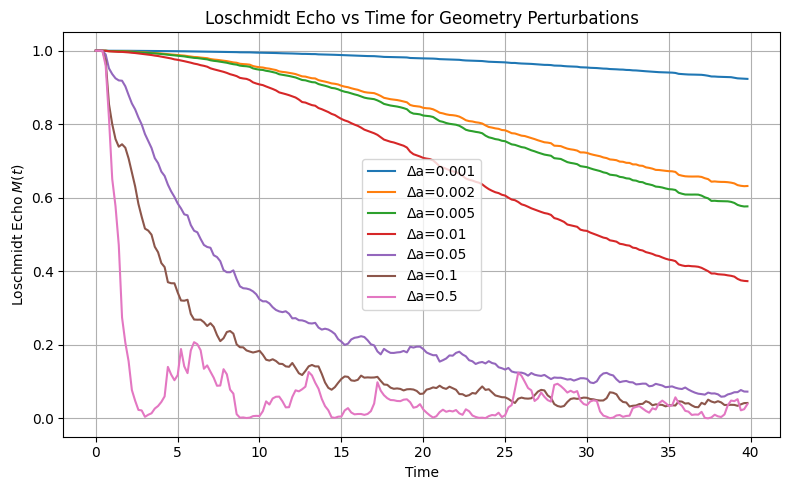

In [5]:
# --- Range of perturbations in 'a' ---
perturbations = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5]

def build_CN_for_mask(mask, free_points):
    rows, cols, data = [], [], []
    for i, idx in enumerate(free_points):
        rows.append(i); cols.append(idx); data.append(1)
    P = csr_matrix((data, (rows, cols)), shape=(len(free_points), Nx*Ny))
    L_free = P @ L @ P.T
    I_free = eye(len(free_points))
    H_free = - (hbar**2)/(2*m) * L_free
    A = (I_free + 1j * dt / (2*hbar) * H_free).tocsc()
    B = (I_free - 1j * dt / (2*hbar) * H_free).tocsc()
    LU = splu(A)
    return P, H_free, A, B, LU, free_points

# Unperturbed system
mask0 = stadium_mask(X, Y, a, b, rx, ry)
free0 = np.where(mask0.flatten())[0]
P0, H0, A0, B0, LU0, free0 = build_CN_for_mask(mask0, free0)

# Initial wavefunction on full grid
psi0_full = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2)/(2*sigma**2))
psi0_full = psi0_full.astype(np.complex128) * np.exp(1j*(px*X+py*Y)/hbar)
psi0_vec = psi0_full.flatten()

# Restrict & normalize for unperturbed
psi0_free0 = psi0_vec[free0].copy()
norm0 = np.sum(np.abs(psi0_free0)**2) * dx*dy
psi0_free0 /= np.sqrt(norm0)

# --- Loop over perturbations ---
plt.figure(figsize=(8,5))

for delta_a in perturbations:
    # Perturbed mask/system
    mask1 = stadium_mask(X, Y, a+delta_a, b, rx, ry)
    free1 = np.where(mask1.flatten())[0]
    P1, H1, A1, B1, LU1, free1 = build_CN_for_mask(mask1, free1)

    # Restrict & normalize for perturbed
    psi0_free1 = psi0_vec[free1].copy()
    norm1 = np.sum(np.abs(psi0_free1)**2) * dx*dy
    psi0_free1 /= np.sqrt(norm1)

    # Initialize states
    psi_free0 = psi0_free0.copy()
    psi_free1 = psi0_free1.copy()

    echo_times, echo_vals = [], []

    for n in range(T_steps):
        # evolve H0
        b0 = B0 @ psi_free0
        psi_free0 = LU0.solve(b0)

        # evolve H1
        b1 = B1 @ psi_free1
        psi_free1 = LU1.solve(b1)

        if n % 20 == 0:
            t = (n+1)*dt
            psi_full0 = np.zeros(Nx*Ny, dtype=complex)
            psi_full1 = np.zeros(Nx*Ny, dtype=complex)
            psi_full0[free0] = psi_free0
            psi_full1[free1] = psi_free1
            overlap = dx*dy * np.vdot(psi_full0, psi_full1)
            echo_vals.append(np.abs(overlap)**2)
            echo_times.append(t)

    plt.plot(echo_times, echo_vals, label=f"Δa={delta_a}")

# --- Final plot ---
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo vs Time for Geometry Perturbations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
from scipy.optimize import curve_fit

def exp_decay(t, gamma, A):
    return A * np.exp(-gamma * t)

plt.figure(figsize=(8,5))
gammas = []


for delta_a in perturbations:
    # ...existing code for echo_times, echo_vals...
    # Fit only the region where echo_vals > 0 (to avoid log(0) issues)
    echo_times_arr = np.array(echo_times)
    echo_vals_arr = np.array(echo_vals)
    mask = echo_vals_arr > 1e-8
    t_fit = echo_times_arr[mask]
    M_fit = echo_vals_arr[mask]
    if len(t_fit) > 5:
        try:
            popt, _ = curve_fit(exp_decay, t_fit, M_fit, p0=(1.0, 1.0))
            gamma, A = popt
            gammas.append((delta_a, gamma))
            plt.plot(echo_times, echo_vals, label=f"Δa={delta_a} (γ={gamma:.3f})")
            plt.plot(t_fit, exp_decay(t_fit, gamma, A), 'k--', alpha=0.6)
        except Exception as e:
            plt.plot(echo_times, echo_vals, label=f"Δa={delta_a} (fit failed)")
    else:
        plt.plot(echo_times, echo_vals, label=f"Δa={delta_a} (insufficient data)")

plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo vs Time for Geometry Perturbations\nwith Exponential Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print gamma for each perturbation
for delta_a, gamma in gammas:
    print(f"Δa={delta_a}: gamma={gamma:.4f}")

NameError: name 'perturbations' is not defined

<Figure size 800x500 with 0 Axes>

Perturbations: 100%|██████████| 7/7 [04:55<00:00, 42.16s/it]


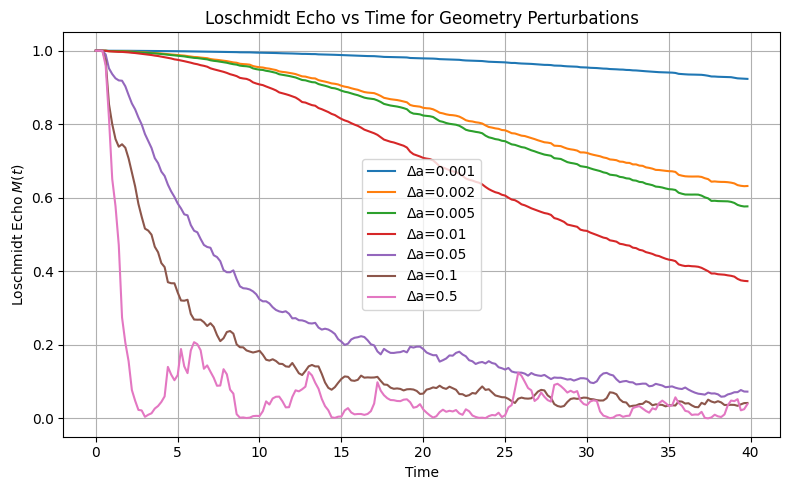

In [6]:
from tqdm import tqdm

# --- Range of perturbations in 'a' ---
perturbations = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5]

def build_CN_for_mask(mask, free_points):
    rows, cols, data = [], [], []
    for i, idx in enumerate(free_points):
        rows.append(i); cols.append(idx); data.append(1)
    P = csr_matrix((data, (rows, cols)), shape=(len(free_points), Nx*Ny))
    L_free = P @ L @ P.T
    I_free = eye(len(free_points))
    H_free = - (hbar**2)/(2*m) * L_free
    A = (I_free + 1j * dt / (2*hbar) * H_free).tocsc()
    B = (I_free - 1j * dt / (2*hbar) * H_free).tocsc()
    LU = splu(A)
    return P, H_free, A, B, LU, free_points

# Unperturbed system
mask0 = stadium_mask(X, Y, a, b, rx, ry)
free0 = np.where(mask0.flatten())[0]
P0, H0, A0, B0, LU0, free0 = build_CN_for_mask(mask0, free0)

# Initial wavefunction on full grid
psi0_full = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2)/(2*sigma**2))
psi0_full = psi0_full.astype(np.complex128) * np.exp(1j*(px*X+py*Y)/hbar)
psi0_vec = psi0_full.flatten()

# Restrict & normalize for unperturbed
psi0_free0 = psi0_vec[free0].copy()
norm0 = np.sum(np.abs(psi0_free0)**2) * dx*dy
psi0_free0 /= np.sqrt(norm0)

# --- Loop over perturbations ---
plt.figure(figsize=(8,5))

for delta_a in tqdm(perturbations, desc="Perturbations"):
    # Perturbed mask/system
    mask1 = stadium_mask(X, Y, a+delta_a, b, rx, ry)
    free1 = np.where(mask1.flatten())[0]
    P1, H1, A1, B1, LU1, free1 = build_CN_for_mask(mask1, free1)

    # Restrict & normalize for perturbed
    psi0_free1 = psi0_vec[free1].copy()
    norm1 = np.sum(np.abs(psi0_free1)**2) * dx*dy
    psi0_free1 /= np.sqrt(norm1)

    # Initialize states
    psi_free0 = psi0_free0.copy()
    psi_free1 = psi0_free1.copy()

    echo_times, echo_vals = [], []

    # Inner loop progress bar (optional, shows time evolution)
    for n in tqdm(range(T_steps), leave=False, desc=f"Δa={delta_a}"):
        # evolve H0
        b0 = B0 @ psi_free0
        psi_free0 = LU0.solve(b0)

        # evolve H1
        b1 = B1 @ psi_free1
        psi_free1 = LU1.solve(b1)

        if n % 20 == 0:
            t = (n+1)*dt
            psi_full0 = np.zeros(Nx*Ny, dtype=complex)
            psi_full1 = np.zeros(Nx*Ny, dtype=complex)
            psi_full0[free0] = psi_free0
            psi_full1[free1] = psi_free1
            overlap = dx*dy * np.vdot(psi_full0, psi_full1)
            echo_vals.append(np.abs(overlap)**2)
            echo_times.append(t)

    plt.plot(echo_times, echo_vals, label=f"Δa={delta_a}")

# --- Final plot ---
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo vs Time for Geometry Perturbations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Perturbations:   0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_30087/4115718617.py:86: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exp_decay, echo_times, echo_vals, p0=[0.1])
Perturbations: 100%|██████████| 8/8 [04:55<00:00, 36.93s/it]


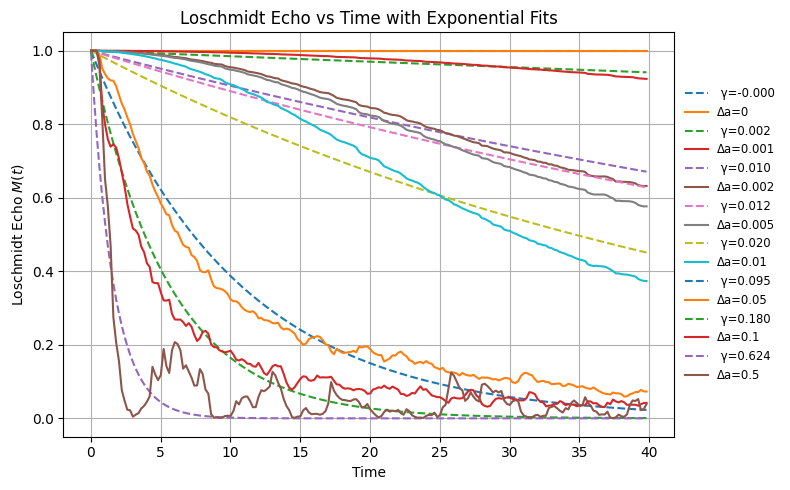


Extracted γ values:
Δa=0: γ=-1.0624316257621968e-11
Δa=0.001: γ=0.0015199652840808126
Δa=0.002: γ=0.01002454650583561
Δa=0.005: γ=0.011673061163007098
Δa=0.01: γ=0.020002911649605656
Δa=0.05: γ=0.09487224112187972
Δa=0.1: γ=0.18044726853754797
Δa=0.5: γ=0.6237942236703193


In [12]:
from tqdm import tqdm
from scipy.optimize import curve_fit

# --- Range of perturbations in 'a' ---
perturbations = [0,0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.5]

def build_CN_for_mask(mask, free_points):
    rows, cols, data = [], [], []
    for i, idx in enumerate(free_points):
        rows.append(i); cols.append(idx); data.append(1)
    P = csr_matrix((data, (rows, cols)), shape=(len(free_points), Nx*Ny))
    L_free = P @ L @ P.T
    I_free = eye(len(free_points))
    H_free = - (hbar**2)/(2*m) * L_free
    A = (I_free + 1j * dt / (2*hbar) * H_free).tocsc()
    B = (I_free - 1j * dt / (2*hbar) * H_free).tocsc()
    LU = splu(A)
    return P, H_free, A, B, LU, free_points

# Unperturbed system
mask0 = stadium_mask(X, Y, a, b, rx, ry)
free0 = np.where(mask0.flatten())[0]
P0, H0, A0, B0, LU0, free0 = build_CN_for_mask(mask0, free0)

# Initial wavefunction on full grid
psi0_full = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2)/(2*sigma**2))
psi0_full = psi0_full.astype(np.complex128) * np.exp(1j*(px*X+py*Y)/hbar)
psi0_vec = psi0_full.flatten()

# Restrict & normalize for unperturbed
psi0_free0 = psi0_vec[free0].copy()
norm0 = np.sum(np.abs(psi0_free0)**2) * dx*dy
psi0_free0 /= np.sqrt(norm0)

# Exponential model
def exp_decay(t, gamma):
    return np.exp(-gamma * t)

gammas = {}

# --- Loop over perturbations ---
plt.figure(figsize=(8,5))

for delta_a in tqdm(perturbations, desc="Perturbations"):
    # Perturbed mask/system
    mask1 = stadium_mask(X, Y, a+delta_a, b, rx, ry)
    free1 = np.where(mask1.flatten())[0]
    P1, H1, A1, B1, LU1, free1 = build_CN_for_mask(mask1, free1)

    # Restrict & normalize for perturbed
    psi0_free1 = psi0_vec[free1].copy()
    norm1 = np.sum(np.abs(psi0_free1)**2) * dx*dy
    psi0_free1 /= np.sqrt(norm1)

    # Initialize states
    psi_free0 = psi0_free0.copy()
    psi_free1 = psi0_free1.copy()

    echo_times, echo_vals = [], []

    # Inner loop progress bar
    for n in tqdm(range(T_steps), leave=False, desc=f"Δa={delta_a}"):
        # evolve H0
        b0 = B0 @ psi_free0
        psi_free0 = LU0.solve(b0)

        # evolve H1
        b1 = B1 @ psi_free1
        psi_free1 = LU1.solve(b1)

        if n % 20 == 0:
            t = (n+1)*dt
            psi_full0 = np.zeros(Nx*Ny, dtype=complex)
            psi_full1 = np.zeros(Nx*Ny, dtype=complex)
            psi_full0[free0] = psi_free0
            psi_full1[free1] = psi_free1
            overlap = dx*dy * np.vdot(psi_full0, psi_full1)
            echo_vals.append(np.abs(overlap)**2)
            echo_times.append(t)

    echo_times = np.array(echo_times)
    echo_vals = np.array(echo_vals)

    # --- Fit to exponential ---
    try:
        popt, pcov = curve_fit(exp_decay, echo_times, echo_vals, p0=[0.1])
        gamma_fit = popt[0]
        gammas[delta_a] = gamma_fit
        fit_curve = exp_decay(echo_times, gamma_fit)
        plt.plot(echo_times, fit_curve, "--", label=f" γ={gamma_fit:.3f}")
    except RuntimeError:
        gammas[delta_a] = None
        print(f"Fit failed for Δa={delta_a}")

    # Plot raw data
    plt.plot(echo_times, echo_vals, label=f"Δa={delta_a}")

# --- Final plot ---
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo vs Time with Exponential Fits")
plt.legend(
    fontsize='small',
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False
)

plt.grid(True)
plt.tight_layout()
plt.show()

# Print gamma values
print("\nExtracted γ values:")
for da, g in gammas.items():
    print(f"Δa={da}: γ={g}")


Perturbations: 100%|██████████| 1/1 [00:33<00:00, 33.81s/it]


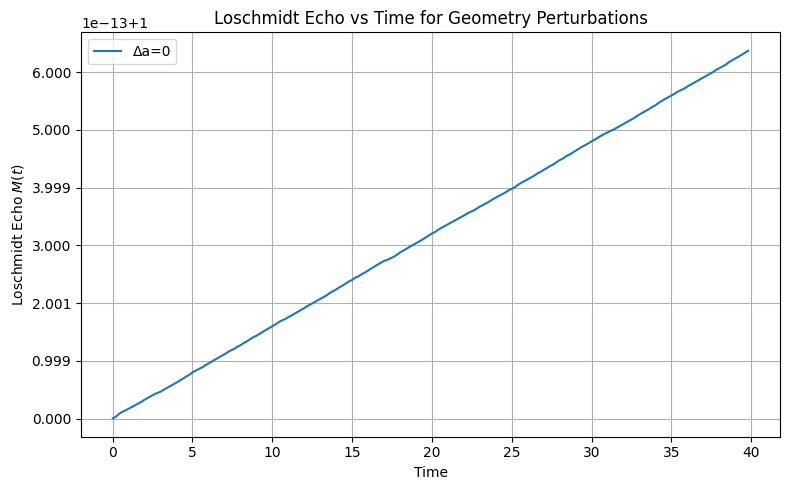

In [11]:
from tqdm import tqdm

# --- Range of perturbations in 'a' ---
perturbations = [0]

def build_CN_for_mask(mask, free_points):
    rows, cols, data = [], [], []
    for i, idx in enumerate(free_points):
        rows.append(i); cols.append(idx); data.append(1)
    P = csr_matrix((data, (rows, cols)), shape=(len(free_points), Nx*Ny))
    L_free = P @ L @ P.T
    I_free = eye(len(free_points))
    H_free = - (hbar**2)/(2*m) * L_free
    A = (I_free + 1j * dt / (2*hbar) * H_free).tocsc()
    B = (I_free - 1j * dt / (2*hbar) * H_free).tocsc()
    LU = splu(A)
    return P, H_free, A, B, LU, free_points

# Unperturbed system
mask0 = stadium_mask(X, Y, a, b, rx, ry)
free0 = np.where(mask0.flatten())[0]
P0, H0, A0, B0, LU0, free0 = build_CN_for_mask(mask0, free0)

# Initial wavefunction on full grid
psi0_full = np.sqrt(1 / (np.pi * sigma**2)) * np.exp(-((X - x0)**2 + (Y - y0)**2)/(2*sigma**2))
psi0_full = psi0_full.astype(np.complex128) * np.exp(1j*(px*X+py*Y)/hbar)
psi0_vec = psi0_full.flatten()

# Restrict & normalize for unperturbed
psi0_free0 = psi0_vec[free0].copy()
norm0 = np.sum(np.abs(psi0_free0)**2) * dx*dy
psi0_free0 /= np.sqrt(norm0)

# --- Loop over perturbations ---
plt.figure(figsize=(8,5))

for delta_a in tqdm(perturbations, desc="Perturbations"):
    # Perturbed mask/system
    mask1 = stadium_mask(X, Y, a+delta_a, b, rx, ry)
    free1 = np.where(mask1.flatten())[0]
    P1, H1, A1, B1, LU1, free1 = build_CN_for_mask(mask1, free1)

    # Restrict & normalize for perturbed
    psi0_free1 = psi0_vec[free1].copy()
    norm1 = np.sum(np.abs(psi0_free1)**2) * dx*dy
    psi0_free1 /= np.sqrt(norm1)

    # Initialize states
    psi_free0 = psi0_free0.copy()
    psi_free1 = psi0_free1.copy()

    echo_times, echo_vals = [], []

    # Inner loop progress bar (optional, shows time evolution)
    for n in tqdm(range(T_steps), leave=False, desc=f"Δa={delta_a}"):
        # evolve H0
        b0 = B0 @ psi_free0
        psi_free0 = LU0.solve(b0)

        # evolve H1
        b1 = B1 @ psi_free1
        psi_free1 = LU1.solve(b1)

        if n % 20 == 0:
            t = (n+1)*dt
            psi_full0 = np.zeros(Nx*Ny, dtype=complex)
            psi_full1 = np.zeros(Nx*Ny, dtype=complex)
            psi_full0[free0] = psi_free0
            psi_full1[free1] = psi_free1
            overlap = dx*dy * np.vdot(psi_full0, psi_full1)
            echo_vals.append(np.abs(overlap)**2)
            echo_times.append(t)

    plt.plot(echo_times, echo_vals, label=f"Δa={delta_a}")

# --- Final plot ---
plt.xlabel("Time")
plt.ylabel("Loschmidt Echo $M(t)$")
plt.title("Loschmidt Echo vs Time for Geometry Perturbations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Perturbing ry: 100%|██████████| 3/3 [01:50<00:00, 36.84s/it]


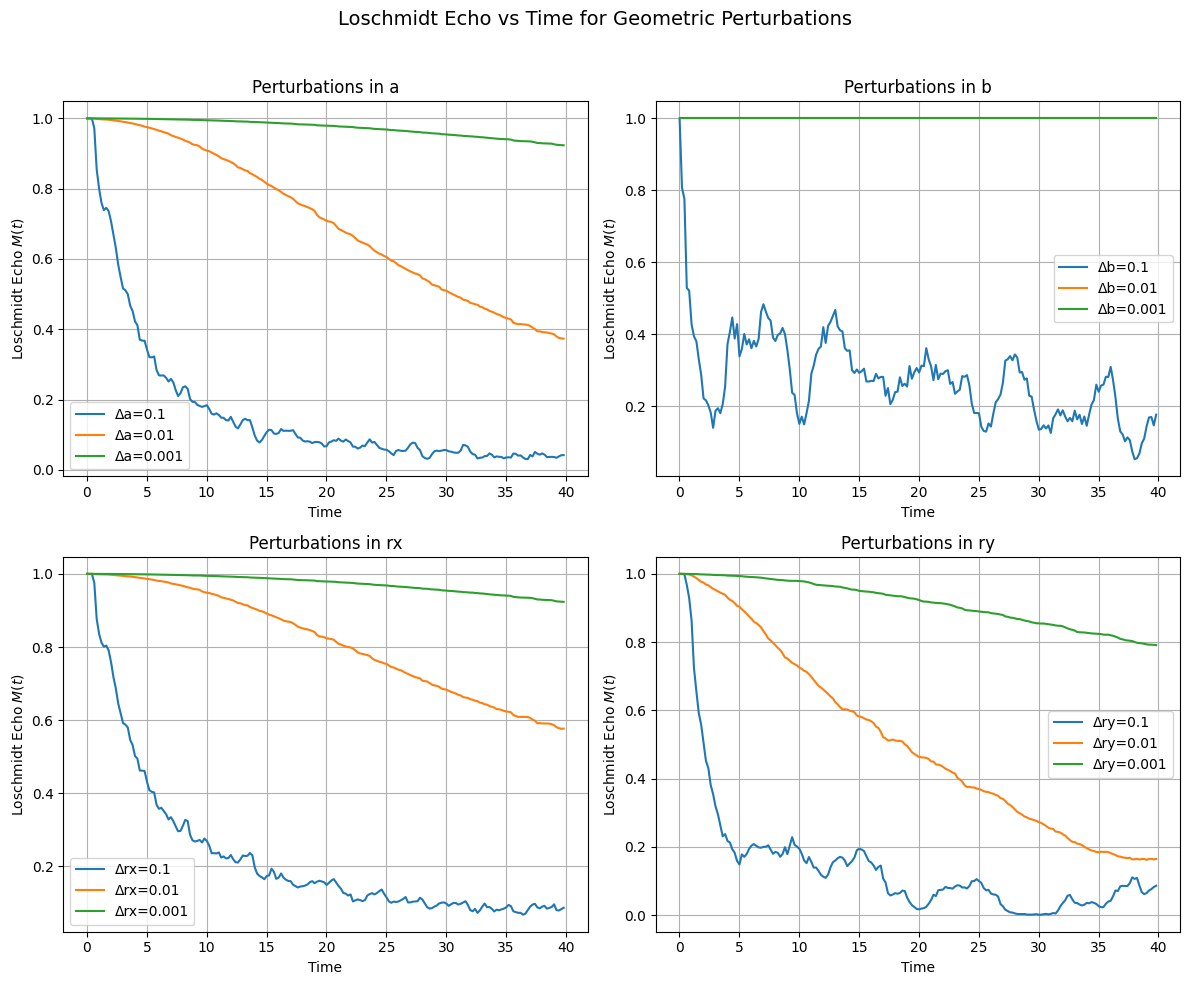

In [13]:
from tqdm import tqdm

# --- Perturbation sizes ---
perturbations = [0.1, 0.01, 0.001]
params = ["a", "b", "rx", "ry"]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, param in enumerate(params):
    ax = axes[i]
    for delta in tqdm(perturbations, desc=f"Perturbing {param}"):
        # Perturbed geometry
        a1, b1, rx1, ry1 = a, b, rx, ry
        if param == "a":
            a1 = a + delta
        elif param == "b":
            b1 = b + delta
        elif param == "rx":
            rx1 = rx + delta
        elif param == "ry":
            ry1 = ry + delta

        # Build perturbed system
        mask1 = stadium_mask(X, Y, a1, b1, rx1, ry1)
        free1 = np.where(mask1.flatten())[0]
        P1, H1, A1, B1, LU1, free1 = build_CN_for_mask(mask1, free1)

        # Restrict & normalize
        psi0_free1 = psi0_vec[free1].copy()
        norm1 = np.sum(np.abs(psi0_free1)**2) * dx * dy
        psi0_free1 /= np.sqrt(norm1)

        # Initialize states
        psi_free0 = psi0_free0.copy()
        psi_free1 = psi0_free1.copy()

        echo_times, echo_vals = [], []

        # Time evolution
        for n in range(T_steps):
            b0 = B0 @ psi_free0
            psi_free0 = LU0.solve(b0)

            b1 = B1 @ psi_free1
            psi_free1 = LU1.solve(b1)

            if n % 20 == 0:
                t = (n+1) * dt
                psi_full0 = np.zeros(Nx*Ny, dtype=complex)
                psi_full1 = np.zeros(Nx*Ny, dtype=complex)
                psi_full0[free0] = psi_free0
                psi_full1[free1] = psi_free1
                overlap = dx * dy * np.vdot(psi_full0, psi_full1)
                echo_vals.append(np.abs(overlap)**2)
                echo_times.append(t)

        # Plot inside this subplot
        ax.plot(echo_times, echo_vals, label=f"Δ{param}={delta}")

    ax.set_title(f"Perturbations in {param}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Loschmidt Echo $M(t)$")
    ax.legend()
    ax.grid(True)

plt.suptitle("Loschmidt Echo vs Time for Geometric Perturbations", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
